## Data collection
We will use dataset of `hatespeechdata.com`.
Both of the data sets are in portuguese.
* A Hierarchically-Labeled Portuguese Hate Speech Dataset: https://b2share.eudat.eu/records/9005efe2d6be4293b63c3cffd4cf193e
* Offensive Comments in the Brazilian Web: A Dataset and Baseline Results: https://github.com/rogersdepelle/OffComBR



In [2]:
import pandas as pd

g1_dataset = pd.read_csv('C:\\Users\\Acer\\Documents\\Studies\\Ciência de Dados e Big Data\\13. TCC\\hate_speech_detector\\data\\OffComBR-master\\OffComBR3.csv')
twitter_dataset = pd.read_csv('C:\\Users\\Acer\\Documents\\Studies\\Ciência de Dados e Big Data\\13. TCC\\hate_speech_detector\\data\\B2Share_eudat\\twitter_dataset.csv')

### Aggregate datasets
As we can see, our datasets are on different formats. One has the tweet ID and indicates the "class of hate", while the other contains the data as pure text and includes the information yes/no for hate.

#### 1st step: dropping NA values
When getting tweet text from tweet ID, we noticed that some tweets or accounts were already deleted (eg.: el 308). We included them in our database as 'Null' value. We are going to delete them now.

In [3]:
# dropping all NA values, we'll delete those tweets that are not available anymore.
# as we can't check the content, I prefered to drop them.
twitter_dataset = twitter_dataset.dropna()
twitter_dataset.shape

(1626, 81)

#### 2nd step: separate only the columns to be used

In [4]:
twitter_dataset = twitter_dataset[['data', 'Hate.speech']]
twitter_dataset.head() 

,data,Hate.speech
0,"""não come mel, morde marimbondo""",0
1,"não tem pinto, tem orgulho !",0
2,Não vê essa merda de Crepúsculo! Pra isso temo...,0
3,"não da tapa na bundinha, da cotovelada nas cos...",0
4,o diminutivo INHO não acompanha a trajetória d...,1


#### 3rd step: change g1_dataset to be on twitter_dataset format
I'll do it by changing the order of data and class and change class from yes/no to 1/0.

In [5]:
cols = g1_dataset.columns.tolist()
cols = cols[::-1] #reverting cols

In [6]:
g1_dataset = g1_dataset[cols]
g1_dataset.head()

,data,class
0,'Votaram no PEZAO Agora tomem no CZAO',yes
1,'cuidado com a poupanca pessoal Lembram o que ...,no
2,'Sabe o que eu acho engracado os nossos govern...,no
3,'Podiam retirar dos lucros dos bancos ',no
4,'CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUU...,no


In [7]:
g1_dataset['class'] = g1_dataset['class'].map({'yes': 1, 'no': 0})
g1_dataset.head()

,data,class
0,'Votaram no PEZAO Agora tomem no CZAO',1
1,'cuidado com a poupanca pessoal Lembram o que ...,0
2,'Sabe o que eu acho engracado os nossos govern...,0
3,'Podiam retirar dos lucros dos bancos ',0
4,'CADE O GALVAO PRA NARRAR AGORA FALIIIIUUUUU...,0


In [8]:
# change the name of "class" column to "Hate.speech"
g1_dataset.columns = ['data', 'Hate.speech']

#### 4th step: Create a complete dataset with g1 and twitter datasets

In [9]:
frames = [twitter_dataset, g1_dataset] 
full_dataset =  pd.concat(frames, ignore_index=True)

full_dataset

,data,Hate.speech
0,"""não come mel, morde marimbondo""",0
1,"não tem pinto, tem orgulho !",0
2,Não vê essa merda de Crepúsculo! Pra isso temo...,0
3,"não da tapa na bundinha, da cotovelada nas cos...",0
4,o diminutivo INHO não acompanha a trajetória d...,1
...,...,...
2652,'Cruz so tem agilidade mesmo poder de nocaute ...,0
2653,'Meus caros amigos enigmaticosNao deveriam com...,0
2654,'Ele chamava pra atras da escola e sentava nos...,1
2655,'Jhalim Rabei ate fiquei assustado comecei a l...,0


### Data enrichment

In [10]:
#!pip install pyspellchecker
#https://pypi.org/project/pyspellchecker/

from spellchecker import SpellChecker
spell = SpellChecker(language='pt') # spell checker in portuguese

def is_unknown(word):
    return spell.unknown([word]) != set()

def count_misspell(text):
    count = 0
    for word in text:
        if '#' not in word or '@' not in word or word != 'rt':
            if is_unknown(word):
                count += 1
    return count

def correct_misspell(text):
    new_text = []
    for word in text:
        if '#' not in word or '@' not in word or word != 'rt' or is_unknown(word):
            correct = spell.correction(word)
            new_text.append(correct)
    return new_text

In [11]:
# get stopwords
import nltk
import re #regex
import string

# remove '#' and '@' to get hashtags and mentions
punct = string.punctuation.replace('#','').replace('@','')
# get stop words in portuguese
stopwords = nltk.corpus.stopwords.words('portuguese')
# get regex for laughs
laughs = "k{2,}|a*ha+h[ha]*|e*he+h[he]*|s*rs+r[rs]*"

# get file with bad words list
# Ranzi, C. (2017) “lista-palavroes-bloqueio.txt”.
#Disponível em: https://pt.scribd.com/document/345921799/lista-palavroes-bloqueio-txt.
f = open("lista-palavroes-bloqueio.txt", "r")
list_bad_words = f.readlines()
list_bad_words = [x.strip() for x in list_bad_words]
f.close()

def count_laughs(text):
    all_laughs = re.findall(laughs, text)
    all_laughs = ''.join(all_laughs)
    return len(all_laughs)

def count_bad_words(text):
    bad = []
    for bad_word in list_bad_words:
        try:
            x = [re.findall('^' + bad_word.lower(), word) for word in text]
            x = [y for y in x if y != []]
            if x != []:
                bad.append(x[0][0])
        except:
            pass
    if bad != []:
        bad = set(bad) # get the unique values
    return len(bad)

def lower(text):
    return text.lower()

def remove_punctuation(text):
    text = [char for char in text if char not in punct]
    return ''.join(text)

def remove_laughs(text):
    return re.sub(laughs, '', text)

def bag_of_words(text):
    text = text.split(' ')
    text = list(filter(lambda x: x != '', text)) # remove any empty element
    return text

def remove_links(text):
    for word in text:
        if 'http' in word or '.com' in word:
            text.remove(word)
    return text

def remove_duplicated_letters(text):
    new_text = []
    for word in text:
        if is_unknown(word):
            new_word = [word[0]] # start new word with 1st letter
            for i, letter in enumerate(word[1:]):
                if letter != word[i]:
                    new_word.append(letter)
            new_word = ''.join(new_word)
        else:
            new_word = word
        new_text.append(new_word)
    return ''.join(new_text)
                
def remove_stopwords(text):
    text = text.split(' ')
    text_without_stopwords = [word for word in text if word not in stopwords] # remove stopwords
    # some elements of the dataset were only stopwords (eg: "quando foi isso")
    # if it's the case, we won't remove stopwords
    if text_without_stopwords != []:
        text = text_without_stopwords
    return ' '.join(text)

def stemming(text):
    stemmer = nltk.stem.RSLPStemmer() #need to download rslp
    text = stemmer.stem(text)
    return text


def process_text(text):
    text = lower(text)
    text = remove_punctuation(text)
    text = remove_laughs(text)
    
    text = remove_links(text)
    #print('remove_links: ' + text)
    text = remove_duplicated_letters(text)
    #print('remove_duplicated_letters: ' + text)
    
    # remove stopwords and links
    text = remove_stopwords(text)
    #print('remove_stopwords: ' + text)
    
    #text = remove_links(text)
    #print('remove_links: ' + text)
    
    #text = correct_misspell(text)

    #stemming (get words variations)
    text = stemming(text)
    #print('stemming: ' + text)
    text = bag_of_words(text)
    #print('bag_of_words: ' + str(text))

    return text

FileNotFoundError: [Errno 2] No such file or directory: 'lista-palavroes-bloqueio.txt'

In [ ]:
from tqdm import tqdm, tqdm_notebook
tqdm.pandas(tqdm_notebook)

# replace map with progress_map
# where df is a pandas dataframe
#length = full_dataset['data'].progress_map(len)

In [16]:
#data, len_laughs, len_wrong_words, len_bad_words = full_dataset['data'].progress_map(process_text)
data = full_dataset['data'].apply(lower)

data = data.apply(remove_punctuation)

length = data.apply(len)
laughs = data.apply(count_laughs)


In [17]:

data = data.apply(remove_laughs)


TypeError: 'Series' objects are mutable, thus they cannot be hashed

In [ ]:

data = data.apply(remove_links)
data = data.apply(remove_duplicated_letters)
data = data.apply(remove_stopwords)
data = data.apply(bag_of_words)


data

In [131]:
wrong_words = data.progress_map(count_misspell)
bad_words = data.progress_map(count_bad_words)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2657/2657 [00:15<00:00, 170.52it/s]


In [22]:
a = full_dataset['data'].progress_map(process_text)
#full_dataset['length'] = length
#full_dataset['laughs'] = laughs
#full_dataset['wrong_words'] = wrong_words
#full_dataset['bad_words'] = bad_words

#full_dataset.sample(5)

  0%|                                                                                                      | 1/2657 [00:00<00:02, 1002.70it/s]


TypeError: 'Series' objects are mutable, thus they cannot be hashed

### Dealing with imbalanced data
With the plot below, we see that 20% of the data is related to hate, while 80% was detected with no hate.

We are going to use SMOTE technique to deal with it

Ref: "SMOTE: Synthetic Minority Over-sampling Technique". Available on https://arxiv.org/pdf/1106.1813.pdf.

In [23]:
from collections import Counter
counter = Counter(full_dataset['Hate.speech'])
print('Class 0: {}, Class 1: {}'.format(counter[0],counter[1]))

Class 0: 2130, Class 1: 529


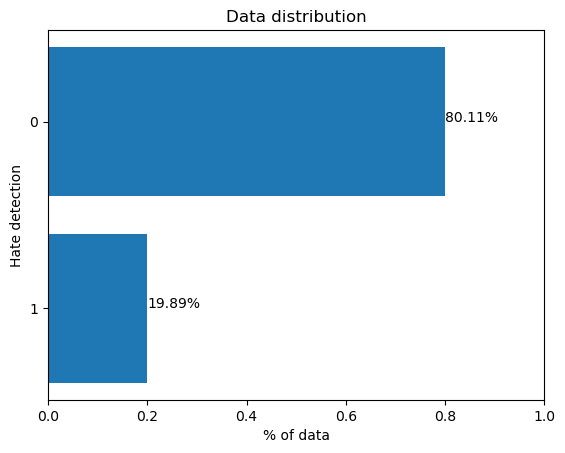

In [25]:
import numpy as np
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
data = (0, 1)
y_pos = np.arange(len(data))

count0 = counter[0]
count1 = counter[1]
total = count0 + count1
amount = (count0/total, count1/total)

ax.barh(y_pos, amount, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(data)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('% of data')
ax.set_ylabel('Hate detection')
ax.set_title('Data distribution')
ax.text(0.8, 0, str(round(amount[0], 4)*100) + '%', color='black')
ax.text(0.2, 1, str(round(amount[1], 4)*100) + '%', color='black')

plt.xlim([0.0, 1.0])
plt.show()

In [26]:
from imblearn.over_sampling import SMOTE
# summarize class distribution
oversample = SMOTE()

a = full_dataset.copy()
a.head()

,data,Hate.speech,length,bad_words
0,"[come, mel, morde, marimbondo]",0,4,0
1,"[pinto, orgulho]",0,2,0
2,"[vê, merda, crepúsculo, pra, cinebiografia, ch...",0,7,1
3,"[tapa, bundinha, cotovelada, costas]",0,4,0
4,"[diminutivo, inho, acompanha, trajetória, home...",1,6,0


### Some analysis

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

In [137]:
full_dataset.groupby('Hate.speech').describe()#.unstack()

length                                                        \
              count       mean        std  min    25%   50%    75%    max   
Hate.speech                                                                 
0            2127.0  88.824165  51.055327  5.0  53.00  81.0  123.0  533.0   
1             530.0  74.152830  42.233186  5.0  42.25  66.0  104.0  426.0   

            len_laughs            ... len_wrong_words       len_bad_words  \
                 count      mean  ...             75%   max         count   
Hate.speech                       ...                                       
0               2127.0  0.412318  ...             3.0  26.0        2127.0   
1                530.0  0.562264  ...             3.0  21.0         530.0   

                                                          
                 mean       std  min  25%  50%  75%  max  
Hate.speech                                               
0            0.170663  0.420013  0.0  0.0  0.0  0.0  3.0  
1            0.522642  0.687765  0.0  0.0  0.0  1.0  4.0  

[2 rows x 32 columns]

array([<matplotlib.axes._subplots.AxesSubplot object at 0x18D49628>,
      dtype=object)

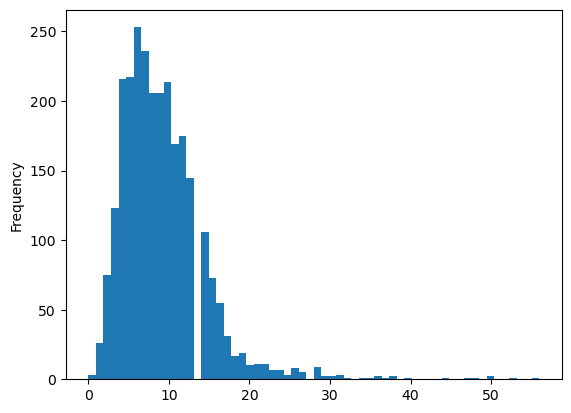

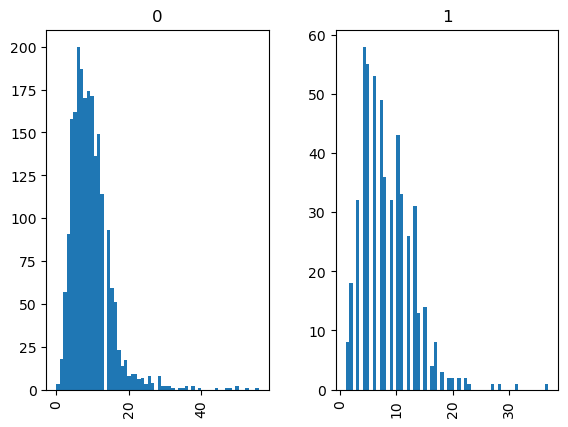

In [52]:
# checking it visually - length
full_dataset['length'].plot.hist(bins=60)
full_dataset.hist(column='length', by='Hate.speech', bins=60)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x18E6A790>,
      dtype=object)

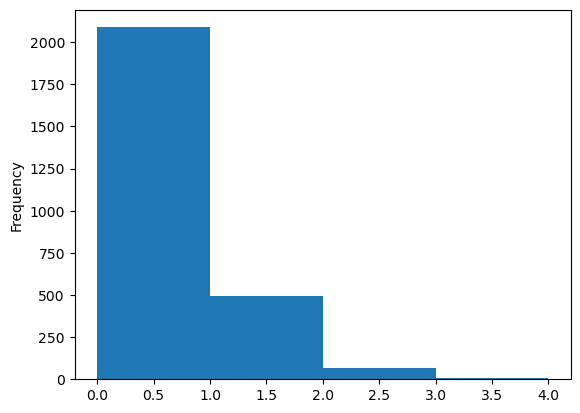

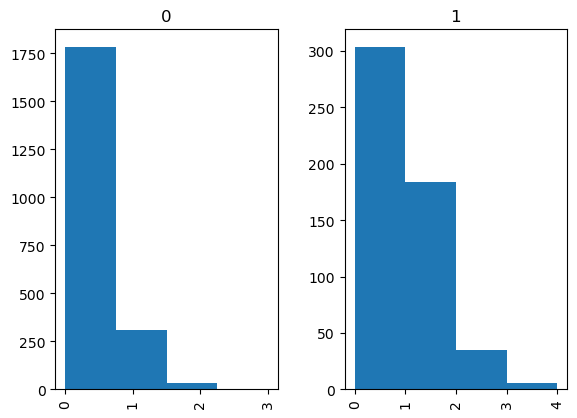

In [55]:
# checking it visually - bad words
full_dataset['bad_words'].plot.hist(bins=4)

full_dataset.hist(column='bad_words', by='Hate.speech', bins=4)

Text(0, 0.5, 'length')

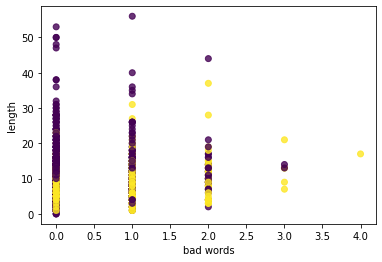

In [57]:
plt.scatter(full_dataset['bad_words'], full_dataset['length'], alpha=0.8,
            c=full_dataset['Hate.speech'])
plt.xlabel('bad words')
plt.ylabel('length')

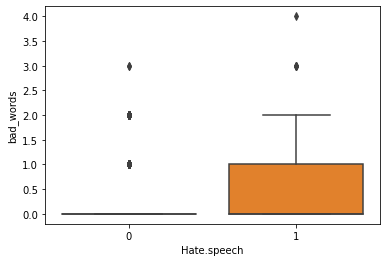

In [61]:
sns.boxplot(x='Hate.speech', y='bad_words', data=full_dataset )

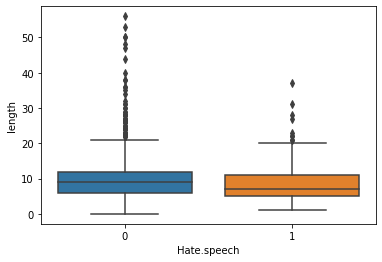

In [62]:
sns.boxplot(x='Hate.speech', y='length', data=full_dataset )

Some conclusions until now are:
* comparing length and bad_words amount when hate speech is detected and when it is not. We see that:
 * class 0: length mean 9.4, bad_words mean 0.18
 * class 1: length mean 8.2, bad_words mean 0.52
* it means that text with hate detected are shorter and has more bad words, in general
* there are many outliers for length (and also for bad words), so we need to be careful

In [66]:
hate = full_dataset.groupby('Hate.speech').mean()
hate.corr()

,length,bad_words
length,1.0,-1.0
bad_words,-1.0,1.0


### Process the data

In [27]:
import nltk #floresta, popular
#nltk.download()
#https://www.nltk.org/howto/portuguese_en.html

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Vectorization TF IDF
1. Count how many times a word occur in each message (Term Frequency)
2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length

We will use CountVectorizer from sklearn

In [155]:
x = full_dataset['data'][0]

join_text(x)

'come mel morde marimbondo'

In [28]:
def join_text(text):
    return ' '.join(text)

# make it a full text again
full_dataset['data'] = full_dataset['data'].apply(join_text)
full_dataset['data'].head()

0                            come mel morde marimbondo
1                                        pinto orgulho
2    vê merda crepúsculo pra cinebiografia chuck no...
3                      tapa bundinha cotovelada costas
4    diminutivo inho acompanha trajetória homem ver...
Name: data, dtype: object

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()
bow_transformer = count_vectorizer.fit(full_dataset['data'])


In [32]:
print(bow_transformer.vocabulary_)
data_bow = bow_transformer.transform(full_dataset['data'])

full_dataset['data']

{'come': 1873, 'mel': 6076, 'morde': 6294, 'marimbondo': 5974, 'pinto': 7255, 'orgulho': 6828, 'vê': 9640, 'merda': 6118, 'crepúsculo': 2235, 'pra': 7443, 'cinebiografia': 1762, 'chuck': 1736, 'norris': 6625, 'tapa': 8878, 'bundinha': 1321, 'cotovelada': 2211, 'costas': 2207, 'diminutivo': 2707, 'inho': 5142, 'acompanha': 237, 'trajetória': 9141, 'homem': 4252, 'verdade': 9456, 'uns': 9314, 'saco': 8319, 'culhões': 2307, 'futebol': 3861, 'hoje': 4248, 'politicamente': 7337, 'correto': 2176, 'profissional': 7602, 'coisa': 1833, 'verdadeé': 9465, 'mariquinhafutebol': 5982, 'ter': 8956, 'porrada': 7380, 'água': 9765, 'ser': 8510, 'essencial': 3291, 'maricas': 5969, 'cerveja': 1637, 'barriga': 1036, 'calo': 1411, 'sexual': 8548, 'manda': 5904, 'ajustar': 412, 'calça': 1415, 'deixa': 2448, 'espaço': 3232, 'smith': 8616, 'wesson': 9668, 'entrar': 3131, 'ação': 971, 'morte': 6316, 'hipsters': 4230, 'camisetas': 1429, 'cores': 2157, 'citricas': 1775, 'meias': 6070, 'coloridinhas': 1866, 'cuequ

0                               come mel morde marimbondo
1                                           pinto orgulho
2       vê merda crepúsculo pra cinebiografia chuck no...
3                         tapa bundinha cotovelada costas
4       diminutivo inho acompanha trajetória homem ver...
                              ...                        
2654    cruz so agilidade poder nocaute zero cody veio...
2655    caros amigos enigmaticosnao deveriam comparalo...
2656             chamava pra atras escola sentava garotos
2657    jhalim rabei ate fiquei assustado comecei ler ...
2658    irmao honorato sempre falando verdades agindo ...
Name: data, Length: 2659, dtype: object

In [33]:
print('Shape of the sparse matrix ', data_bow.shape)

Shape of the sparse matrix  (2659, 10065)


In [34]:
data_bow.nnz

23495

In [35]:
sparsity = (100 * data_bow.nnz/(data_bow.shape[0] * data_bow.shape[1]))
print('Sparsity: {}'.format(sparsity))

Sparsity: 0.0877896530767387


In [36]:
# use sklearn tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

In [37]:
tfidf_transformer = TfidfTransformer().fit(data_bow)

In [38]:
# podemos pegar uma palavra e ver se ela é frequente
tfidf_transformer.idf_[bow_transformer.vocabulary_['futebol']]

5.841558964052322

In [39]:
# agora passando a mensagem toda:
data_tfidf = tfidf_transformer.transform(data_bow)

In [40]:
data_tfidf

<2659x10065 sparse matrix of type '<class 'numpy.float64'>'
	with 23495 stored elements in Compressed Sparse Row format>

In [41]:
#naive bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

In [43]:
X = full_dataset[['data', 'length', 'bad_words']]

data_train, data_test, label_train, label_test = train_test_split(X, full_dataset['Hate.speech'], test_size=0.2)


In [46]:
data_train

,data,length,bad_words
212,moço ótimo carpinejar rt milanuness rindo moço...,9,0
1953,nao forca falta senso ridiculo,5,0
2307,fanatismo nao doenca fisica espiritual sim doe...,9,0
1535,triste bebe brasil fábrica bebum,5,1
259,frasesdemae dá fuçada lá mãe primeiro livro am...,11,0
...,...,...,...
489,rpsantos1970 aproveitamento chamada “crise ref...,8,0
1615,raiane sapatão fld dá mh bunda,6,1
328,rt mundodrogado antes homossexualismo proibido...,14,1
1286,reflexos guerra trouxeram grandes mudanças vid...,9,0


In [44]:
#create a pipeline to do with our separated data
pipeline_NB = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', MultinomialNB())
    #('classifier', RandomForestClassifier())
])

In [45]:
pipeline_NB.fit(data_train, label_train)
predictions_NB = pipeline_NB.predict(data_test)

ValueError: Found input variables with inconsistent numbers of samples: [3, 2127]

In [202]:
#create a pipeline to do with our separated data
pipeline_LSVC = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LinearSVC())
])

In [203]:
pipeline_LSVC.fit(data_train, label_train)
predictions_LSVC = pipeline_LSVC.predict(data_test)

In [204]:
print('Report LinearSVC')
print(classification_report(label_test, predictions_LSVC))

print('Report NB:')
print(classification_report(label_test, predictions_NB))

Report LinearSVC
              precision    recall  f1-score   support

           0       0.88      0.96      0.92       423
           1       0.76      0.50      0.61       109

    accuracy                           0.87       532
   macro avg       0.82      0.73      0.76       532
weighted avg       0.86      0.87      0.86       532

Report NB:
              precision    recall  f1-score   support

           0       0.80      1.00      0.89       423
           1       1.00      0.06      0.10       109

    accuracy                           0.81       532
   macro avg       0.90      0.53      0.50       532
weighted avg       0.84      0.81      0.73       532



With this, we have pretty bad results :)

* Precision: how many are correctly classified among that class -> quando detecta a classe 1, ele está correto 67% das vezes
* Recall: how many of this class you find over the whole number of element of this class -> detecta 22% dos elementos da classe 1
* f1-score: harmonic mean between precision & recall
* Support: number of occurence of the given class in your dataset (221 of class 0, 45 of class 1)

In [ ]:
#Plot Precision-Recall curve for each class and iso-f1 curves

from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

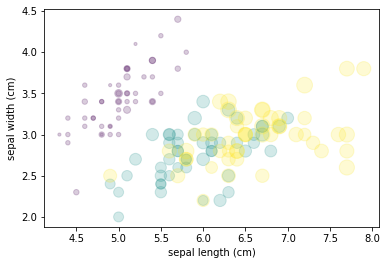

In [26]:
from sklearn.datasets import load_iris
iris = load_iris()
features = iris.data.T

plt.scatter(features[0], features[1], alpha=0.2,
            s=100*features[3], c=iris.target, cmap='viridis')
plt.xlabel(iris.feature_names[0])
plt.ylabel(iris.feature_names[1]);

In [29]:
features[3]

array([0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1, 0.2, 0.2, 0.1,
       0.1, 0.2, 0.4, 0.4, 0.3, 0.3, 0.3, 0.2, 0.4, 0.2, 0.5, 0.2, 0.2,
       0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.1, 0.2, 0.2, 0.2, 0.2, 0.1, 0.2,
       0.2, 0.3, 0.3, 0.2, 0.6, 0.4, 0.3, 0.2, 0.2, 0.2, 0.2, 1.4, 1.5,
       1.5, 1.3, 1.5, 1.3, 1.6, 1. , 1.3, 1.4, 1. , 1.5, 1. , 1.4, 1.3,
       1.4, 1.5, 1. , 1.5, 1.1, 1.8, 1.3, 1.5, 1.2, 1.3, 1.4, 1.4, 1.7,
       1.5, 1. , 1.1, 1. , 1.2, 1.6, 1.5, 1.6, 1.5, 1.3, 1.3, 1.3, 1.2,
       1.4, 1.2, 1. , 1.3, 1.2, 1.3, 1.3, 1.1, 1.3, 2.5, 1.9, 2.1, 1.8,
       2.2, 2.1, 1.7, 1.8, 1.8, 2.5, 2. , 1.9, 2.1, 2. , 2.4, 2.3, 1.8,
       2.2, 2.3, 1.5, 2.3, 2. , 2. , 1.8, 2.1, 1.8, 1.8, 1.8, 2.1, 1.6,
       1.9, 2. , 2.2, 1.5, 1.4, 2.3, 2.4, 1.8, 1.8, 2.1, 2.4, 2.3, 1.9,
       2.3, 2.5, 2.3, 1.9, 2. , 2.3, 1.8])

In [28]:
features

array([[5.1, 4.9, 4.7, 4.6, 5. , 5.4, 4.6, 5. , 4.4, 4.9, 5.4, 4.8, 4.8,
        4.3, 5.8, 5.7, 5.4, 5.1, 5.7, 5.1, 5.4, 5.1, 4.6, 5.1, 4.8, 5. ,
        5. , 5.2, 5.2, 4.7, 4.8, 5.4, 5.2, 5.5, 4.9, 5. , 5.5, 4.9, 4.4,
        5.1, 5. , 4.5, 4.4, 5. , 5.1, 4.8, 5.1, 4.6, 5.3, 5. , 7. , 6.4,
        6.9, 5.5, 6.5, 5.7, 6.3, 4.9, 6.6, 5.2, 5. , 5.9, 6. , 6.1, 5.6,
        6.7, 5.6, 5.8, 6.2, 5.6, 5.9, 6.1, 6.3, 6.1, 6.4, 6.6, 6.8, 6.7,
        6. , 5.7, 5.5, 5.5, 5.8, 6. , 5.4, 6. , 6.7, 6.3, 5.6, 5.5, 5.5,
        6.1, 5.8, 5. , 5.6, 5.7, 5.7, 6.2, 5.1, 5.7, 6.3, 5.8, 7.1, 6.3,
        6.5, 7.6, 4.9, 7.3, 6.7, 7.2, 6.5, 6.4, 6.8, 5.7, 5.8, 6.4, 6.5,
        7.7, 7.7, 6. , 6.9, 5.6, 7.7, 6.3, 6.7, 7.2, 6.2, 6.1, 6.4, 7.2,
        7.4, 7.9, 6.4, 6.3, 6.1, 7.7, 6.3, 6.4, 6. , 6.9, 6.7, 6.9, 5.8,
        6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
       [3.5, 3. , 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1, 3.7, 3.4, 3. ,
        3. , 4. , 4.4, 3.9, 3.5, 3.8, 3.8, 3.4, 3.7, 3.6, 3.3, 3.4, 3. ,
       